# 将原始的sif文件（.nc）转化成tiff文件
- 导入必要的环境
- 构建sif_array函数，读取nc数据返回数组
- 构建array2raster函数，存储为tiff文件
- 构建sif_plot函数，可视化sif数据
- 测试函数功能
- 批处理原始数据

In [1]:
%matplotlib inline
from L2_tools import *
from netCDF4 import Dataset
import numpy as np
import sys
import xarray as xr
from glob import glob
from osgeo import gdal
from osgeo import ogr,osr
import os
from IPython.core.display import HTML
from IPython.display import clear_output
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

c:\python37\lib\site-packages\xarray\core\merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## 1.构建sif_array 函数,返回sif数据，此函数为返回dcSIF的平均值。
- 输入参数为分辨率step，经度最大值lonMax,经度最小值lonMin,纬度最大值latMax,纬度最小值latMin,L2函数返回值tropomi_data

In [2]:
def sif_array_dcSIF_mean(step,lonMax,lonMin,latMax,latMin,tropomi_data):
    #输入L2结果数据集、分辨率（step），空间范围，输出一个数组
    arr_height = int((lonMax-lonMin)/step)
    lat_arr,lon_arr = np.mgrid[latMin:latMax:step,lonMin:lonMax:step]
    sif_arr = np.zeros_like(lat_arr)
    sif_arr = sif_arr-99 #把没有sif数据的区域存储为-99
    for x in range(arr_height): 
        lat_min = latMin+x*step
        lat_max = latMin+(x+1)*step
        for y in range(arr_height):
            lon_min = lonMin+y*step
            lon_max = lonMin+(y+1)*step
            index = np.where((tropomi_data.lon >= lon_min)&(tropomi_data.lon <= lon_max)&(tropomi_data.lat >= lat_min)&(tropomi_data.lat <= lat_max)) 
            index_LT0 = np.where(tropomi_data.dcSIF[index] > 0)#排除小于0的数据
            if tropomi_data.dcSIF[index].size > 0:# 如果区域内sif数据不为空，取平均或者最大值为区域代表值
                sif_mean = tropomi_data.dcSIF[index].mean()*10000
                sif_arr[x,y] = sif_mean
    return(sif_arr)

def sif_array_dcSIF_max(step,lonMax,lonMin,latMax,latMin,tropomi_data):
    #输入L2结果数据集、分辨率（step），空间范围，输出一个数组
    arr_height = int((lonMax-lonMin)/step)
    lat_arr,lon_arr = np.mgrid[latMin:latMax:step,lonMin:lonMax:step]
    sif_arr = np.zeros_like(lat_arr)
    sif_arr = sif_arr-99 #把没有sif数据的区域存储为-99
    for x in range(arr_height): 
        lat_min = latMin+x*step
        lat_max = latMin+(x+1)*step
        for y in range(arr_height):
            lon_min = lonMin+y*step
            lon_max = lonMin+(y+1)*step
            index = np.where((tropomi_data.lon >= lon_min)&(tropomi_data.lon <= lon_max)&(tropomi_data.lat >= lat_min)&(tropomi_data.lat <= lat_max)) 
            index_LT0 = np.where(tropomi_data.dcSIF[index] > 0)#排除小于0的数据
            if tropomi_data.dcSIF[index].size > 0:# 如果区域内sif数据不为空，取平均或者最大值为区域代表值
                sif_mean = tropomi_data.dcSIF[index].max()*10000
                sif_arr[x,y] = sif_mean
    return(sif_arr)

def sif_array_sif_mean(step,lonMax,lonMin,latMax,latMin,tropomi_data):
    #输入L2结果数据集、分辨率（step），空间范围，输出一个数组，把没有sif数据的区域存储为-99，有数据的区域取均值
    arr_height = int((lonMax-lonMin)/step)
    lat_arr,lon_arr = np.mgrid[latMin:latMax:step,lonMin:lonMax:step]
    sif_arr = np.zeros_like(lat_arr)
    sif_arr = sif_arr-99 #把没有sif数据的区域存储为-99
    for x in range(arr_height): 
        lat_min = latMin+x*step
        lat_max = latMin+(x+1)*step
        for y in range(arr_height):
            lon_min = lonMin+y*step
            lon_max = lonMin+(y+1)*step
            index = np.where((tropomi_data.lon >= lon_min)&(tropomi_data.lon <= lon_max)&(tropomi_data.lat >= lat_min)&(tropomi_data.lat <= lat_max)) 
            index_LT0 = np.where(tropomi_data.sif[index] > 0)#排除小于0的数据
            if tropomi_data.sif[index].size > 0:# 如果区域内sif数据不为空，取平均或者最大值为区域代表值
                sif_mean = tropomi_data.sif[index].mean()*10000
                sif_arr[x,y] = sif_mean
    return(sif_arr)

def sif_array_sif_max(step,lonMax,lonMin,latMax,latMin,tropomi_data):
    #输入L2结果数据集、分辨率（step），空间范围，输出一个数组
    arr_height = int((lonMax-lonMin)/step)
    lat_arr,lon_arr = np.mgrid[latMin:latMax:step,lonMin:lonMax:step]
    sif_arr = np.zeros_like(lat_arr)
    sif_arr = sif_arr-99 #把没有sif数据的区域存储为-99
    for x in range(arr_height): 
        lat_min = latMin+x*step
        lat_max = latMin+(x+1)*step
        for y in range(arr_height):
            lon_min = lonMin+y*step
            lon_max = lonMin+(y+1)*step
            index = np.where((tropomi_data.lon >= lon_min)&(tropomi_data.lon <= lon_max)&(tropomi_data.lat >= lat_min)&(tropomi_data.lat <= lat_max)) 
            index_LT0 = np.where(tropomi_data.sif[index] > 0)#排除小于0的数据
            if tropomi_data.sif[index].size > 0:# 如果区域内sif数据不为空，取平均或者最大值为区域代表值
                sif_mean = tropomi_data.sif[index].max()*10000
                sif_arr[x,y] = sif_mean           
    return(sif_arr)

## 2.构建array2raster函数，存储为tiff文件

**仿射地理变换**
GDAL数据集有两种方式表示栅格数据中像元位置（图像中某个点在影像中的行列号）和投影坐标系（不是经纬度，是投影到二维平面的地图坐标，二者可以通过地图投影进行相互转换）间的关系：仿射变换和GCP点。大部分数据都是用仿射变换描述的，本节中描述仿射变换。

仿射变换由六个参数实现， GDALDataset::GetGeoTransform() 可以获取仿射变换参数数组。将像元位置转换为投影坐标的公式如下：


六个参数分别是：
- geos[0]  top left x 左上角x坐标
- geos[1]  w-e pixel resolution 东西方向像素分辨率
- geos[2]  rotation, 0 if image is "north up" 旋转角度，正北向上时为0
- geos[3]  top left y 左上角y坐标
- geos[4]  rotation, 0 if image is "north up" 旋转角度，正北向上时为0
- geos[5]  n-s pixel resolution 南北向像素分辨率
- x/y为图像的x/y坐标，geox/geoy为对应的投影坐标
- geox = geos[0] + geos[1] * x + geos[2] * y
- geoy = geos[3] + geos[4] * x + geos[5] * y

注意，上面所说的点/线坐标系是从左上角(0,0)点到右下角，也就是坐标轴从左到右增长，从上到下增长的坐标系（即影象的行列从左下角开始计算）。 点/线位置中心是(0.5,0.5)

In [3]:
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float64)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

## 3.构建sif_plot函数，可视化sif数据
- 

In [4]:
def sif_plot(latMin,latMax,lonMin,lonMax,sif_arr):
    import matplotlib.pyplot as plt 
    plt.style.use('ggplot')
    plt.figure(figsize = (6,6))
    plt.rcParams['font.sans-serif']=['SimHei']
    # plt.subplot(211)
    lat_arr,lon_arr = np.mgrid[latMin:latMax:0.1,lonMin:lonMax:0.1]
    plt.pcolor(lon_arr,lat_arr,sif_arr)
    plt.title('黄淮海地区SIF均值数据')
    plt.rcParams['axes.unicode_minus'] = False
    plt.colorbar()

## 4.测试函数功能
- L2工具是可以读入多天的数据到一起,这里只用一天。

In [5]:
path  = 'D:/wsy/Data/SIF/TROPO/ungridded/'
outpath = 'D:/wsy/Data/SIF/TROPO/tiff/0.1/dcSIF/MEAN/'
filelist = glob(path+'*.nc')
filelen= len(filelist)
path_tropomi = filelist[0]
t_unit_tropomi = "seconds since 1970-01-01 00:00:00"
t_cal = u"gregorian"
latMin = 30.
latMax = 43.
lonMin = 110.
lonMax = 123.
tropomi_HHH = L2(path_tropomi, dict_tropomi,latMin, latMax, lonMin, lonMax)
tropomi_HHH.time_python = convert_time(tropomi_HHH.time, t_unit_tropomi, t_cal)
sif_arr = sif_array_dcSIF_mean(0.05,lonMax,lonMin,latMax,latMin,tropomi_HHH)
sif_plot(latMin,latMax,lonMin,lonMax,sif_arr)

IndexError: list index out of range

## 5.批处理文件
- 

In [5]:
path  = 'D:/wsy/Data/SIF/TROPO/ungridded_nc/'
outpath = 'D:/wsy/Data/SIF/TROPO/tiff/0.1/sif/mean/'
filelist = glob(path+'*.nc')
filelen= len(filelist)

for file in filelist:
    try:
        filelen = filelen - 1
        path_tropomi = file
        t_unit_tropomi = "seconds since 1970-01-01 00:00:00"
        t_cal = u"gregorian"
        latMin = 30.
        latMax = 43.
        lonMin = 110.
        lonMax = 123.
        tropomi_HHH = L2(path_tropomi, dict_tropomi,latMin, latMax, lonMin, lonMax)
        tropomi_HHH.time_python = convert_time(tropomi_HHH.time, t_unit_tropomi, t_cal)
        #sif_arr = sif_array_dcSIF_max(0.1,lonMax,lonMin,latMax,latMin,tropomi_HHH)
        sif_arr = sif_array_sif_mean(0.1,lonMax,lonMin,latMax,latMin,tropomi_HHH)
        #输出tiff
        rasterOrigin = (110,43)#输出tiff左上角经纬度
        pixelWidth = 0.1
        pixelHeight = -0.1
        newRasterfn = outpath+str(os.path.basename(file)[:-3])+'_SIF_mean.tif'
        reversed_arr = sif_arr[::-1]
        array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr)
        print(newRasterfn+'   还剩下_'+str(filelen)+'_个文件。')
    except:
        print('这个文件出错了')
        continue


D:/wsy/Data/SIF/TROPO/tiff/0.1/sif/mean/TROPO_SIF_2018-09-01_ungridded_SIF_mean.tif   还剩下_301_个文件。
D:/wsy/Data/SIF/TROPO/tiff/0.1/sif/mean/TROPO_SIF_2018-09-02_ungridded_SIF_mean.tif   还剩下_300_个文件。
D:/wsy/Data/SIF/TROPO/tiff/0.1/sif/mean/TROPO_SIF_2018-09-03_ungridded_SIF_mean.tif   还剩下_299_个文件。
D:/wsy/Data/SIF/TROPO/tiff/0.1/sif/mean/TROPO_SIF_2018-09-04_ungridded_SIF_mean.tif   还剩下_298_个文件。
D:/wsy/Data/SIF/TROPO/tiff/0.1/sif/mean/TROPO_SIF_2018-09-05_ungridded_SIF_mean.tif   还剩下_297_个文件。
D:/wsy/Data/SIF/TROPO/tiff/0.1/sif/mean/TROPO_SIF_2018-09-06_ungridded_SIF_mean.tif   还剩下_296_个文件。
D:/wsy/Data/SIF/TROPO/tiff/0.1/sif/mean/TROPO_SIF_2018-09-07_ungridded_SIF_mean.tif   还剩下_295_个文件。
D:/wsy/Data/SIF/TROPO/tiff/0.1/sif/mean/TROPO_SIF_2018-09-08_ungridded_SIF_mean.tif   还剩下_294_个文件。
这个文件出错了
D:/wsy/Data/SIF/TROPO/tiff/0.1/sif/mean/TROPO_SIF_2018-09-10_ungridded_SIF_mean.tif   还剩下_292_个文件。
D:/wsy/Data/SIF/TROPO/tiff/0.1/sif/mean/TROPO_SIF_2018-09-11_ungridded_SIF_mean.tif   还剩下_291_个文件。
D:

------
------
-------

1
2


(array([6986., 7030., 6690., 7247., 7298., 7177., 7131., 7385., 6872.,
        6303., 6628., 7464., 7913., 8937., 7794., 6472., 5869., 6332.,
        7836., 7848., 7942., 8659., 8513., 8597., 8783.]),
 array([30.  , 30.52, 31.04, 31.56, 32.08, 32.6 , 33.12, 33.64, 34.16,
        34.68, 35.2 , 35.72, 36.24, 36.76, 37.28, 37.8 , 38.32, 38.84,
        39.36, 39.88, 40.4 , 40.92, 41.44, 41.96, 42.48, 43.  ],
       dtype=float32),
 <a list of 25 Patch objects>)

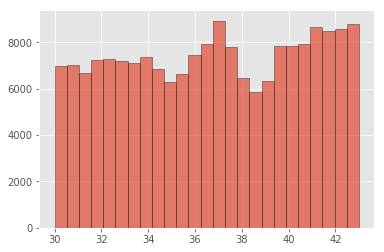

In [2]:
plt.hist(tropomi_HHH.lat,bins = 25,edgecolor="black", alpha=0.7)

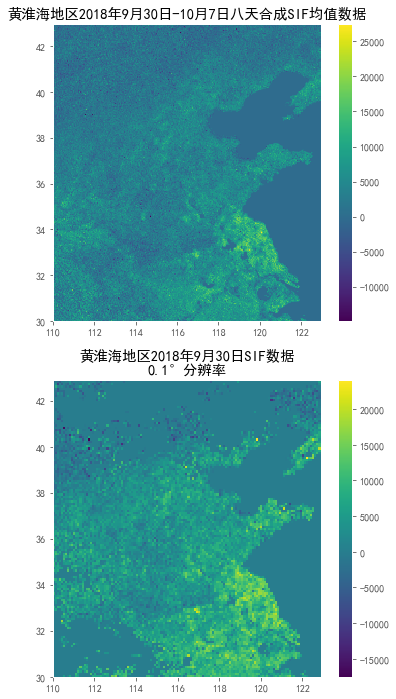

In [3]:
def sif_array(step,lonMax,lonMin,latMax,latMin,tropomi_data):
    #输入L2结果数据集、分辨率（step），空间范围，输出一个数组
    arr_height = int((lonMax-lonMin)/step)
    lat_arr,lon_arr = np.mgrid[latMin:latMax:step,lonMin:lonMax:step]
    sif_arr = np.zeros_like(lat_arr)
    sif_arr = sif_arr-99 #把没有sif数据的区域存储为-99
    for x in range(arr_height): 
        lat_min = latMin+x*step
        lat_max = latMin+(x+1)*step
        for y in range(arr_height):
            lon_min = lonMin+y*step
            lon_max = lonMin+(y+1)*step
            index = np.where((tropomi_data.lon >= lon_min)&(tropomi_data.lon <= lon_max)&(tropomi_data.lat >= lat_min)&(tropomi_data.lat <= lat_max)) 
            index_LT0 = np.where(tropomi_data.sif[index] > 0)#排除小于0的数据
            if tropomi_data.sif[index].size > 0:# 如果区域内sif数据不为空，取平均或者最大值为区域代表值
                sif_mean = tropomi_data.sif[index].mean()*10000
                sif_arr[x,y] = sif_mean
    return(sif_arr)

plt.figure(figsize = (6,12))
plt.rcParams['font.sans-serif']=['SimHei']
sif_arr = sif_array(0.05,lonMax,lonMin,latMax,latMin,tropomi_HHH)
plt.subplot(211)
lat_arr,lon_arr = np.mgrid[latMin:latMax:0.05,lonMin:lonMax:0.05]
plt.pcolor(lon_arr,lat_arr,sif_arr)
plt.title('黄淮海地区2018年9月30日-10月7日八天合成SIF均值数据')
plt.rcParams['axes.unicode_minus'] = False
plt.colorbar()

tropomi_daily_path = 'D:/wsy/Data/SIF/TROPO/ungridded/TROPO_SIF_2018-09-30_ungridded.nc'
tropomi_daily_0930 = L2(tropomi_daily_path, dict_tropomi,latMin, latMax, lonMin, lonMax)
tropomi_daily_0930.time_python = convert_time(tropomi_daily_0930.time, t_unit_tropomi, t_cal)
sif_arr2 = sif_array(0.1,lonMax,lonMin,latMax,latMin,tropomi_daily_0930)
lat_arr2,lon_arr2 = np.mgrid[latMin:latMax:0.1,lonMin:lonMax:0.1]
plt.subplot(212)
plt.pcolor(lon_arr2,lat_arr2,sif_arr2)
plt.rcParams['font.sans-serif']=['SimHei']
plt.title('''黄淮海地区2018年9月30日SIF数据
0.1°分辨率''')
plt.colorbar()
plt.show()



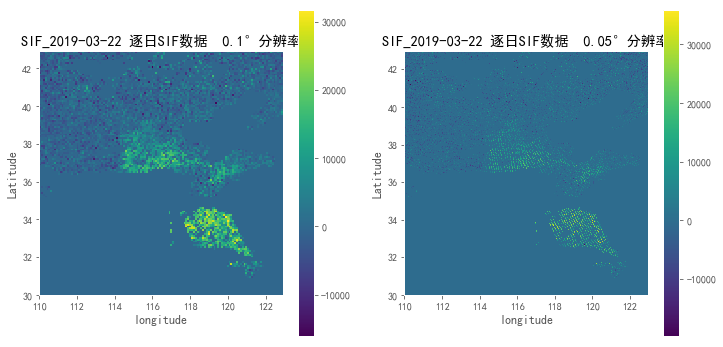

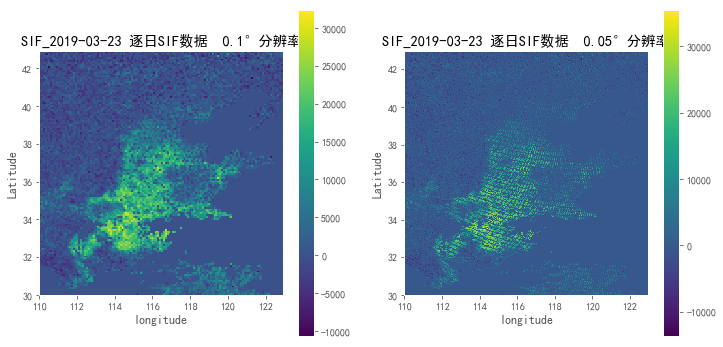

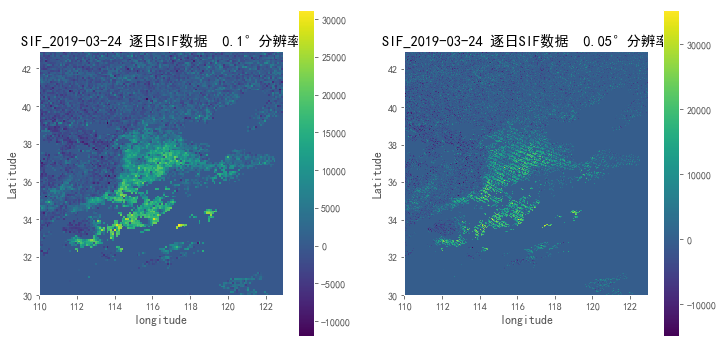

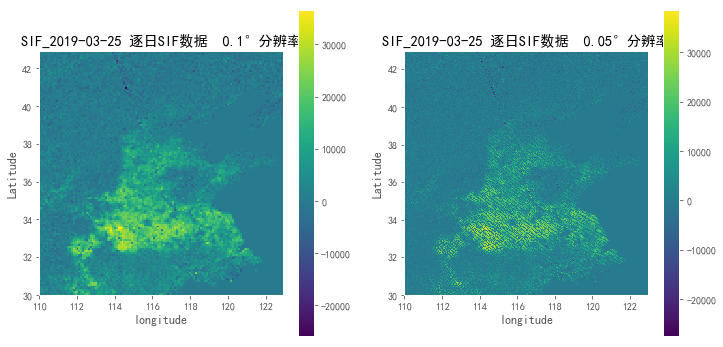

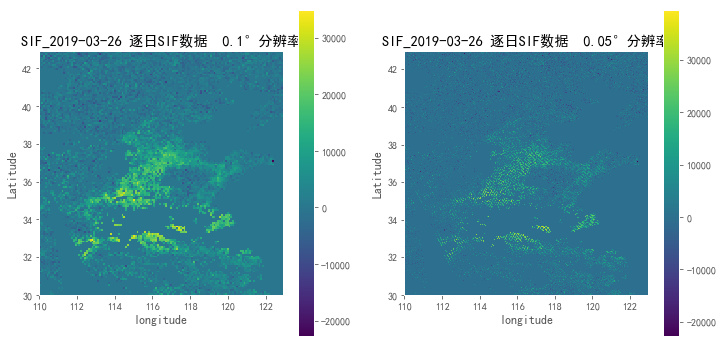

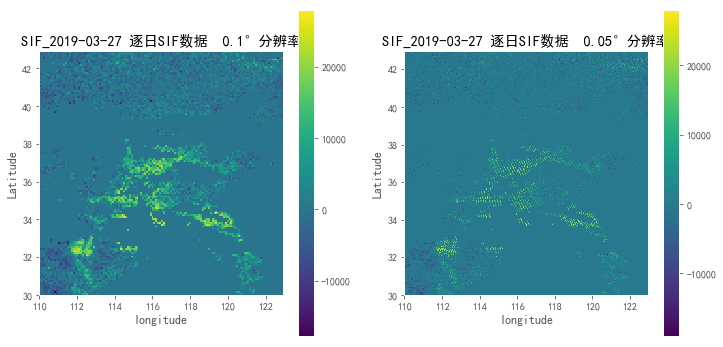

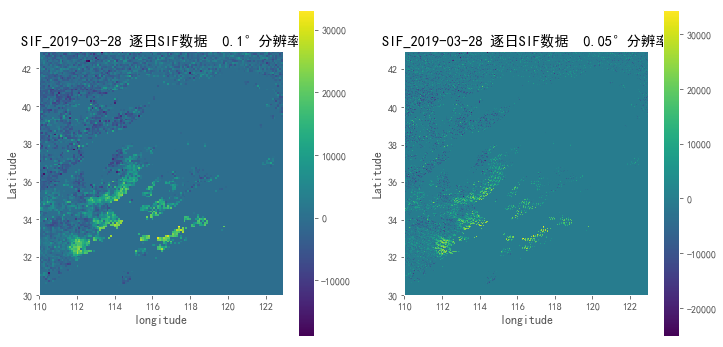

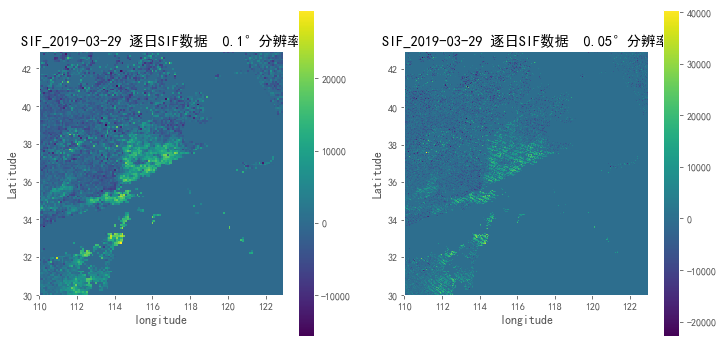

In [26]:
#plot 逐日的sif数据
path_tropomi_201903 = 'D:/wsy/Data/SIF/TROPO/test/SIF8days0322_0329/*.nc'
filelist = glob.glob(path_tropomi_201903)
file_len = len(filelist)
i = 0
for file in filelist:
    i+=1
    tropomi_201903_daily = L2(file, dict_tropomi,latMin, latMax, lonMin, lonMax)
    tropomi_201903_daily.time_python = convert_time(tropomi_201903_daily.time, t_unit_tropomi, t_cal)
    sif_arr = sif_array(0.1,lonMax,lonMin,latMax,latMin,tropomi_201903_daily)
    lat_arr,lon_arr = np.mgrid[latMin:latMax:0.1,lonMin:lonMax:0.1]
    
   
    
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(sif_arr, cmap='viridis', extent=[lon_arr.min(), lon_arr.max(), lat_arr.min(), lat_arr.max()],interpolation='none', origin='lower')
    #plt.pcolor(lon_arr,lat_arr,sif_arr)
    plt.grid(None)
    plt.ylabel('Latitude')
    plt.xlabel('longitude')
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.title(file[-27:-13]+' 逐日SIF数据'+'  0.1°分辨率')
    plt.colorbar()
    
    
    sif_arr = sif_array(0.05,lonMax,lonMin,latMax,latMin,tropomi_201903_daily)
    lat_arr,lon_arr = np.mgrid[latMin:latMax:0.05,lonMin:lonMax:0.05]
    plt.subplot(122)
    plt.imshow(sif_arr, cmap='viridis', extent=[lon_arr.min(), lon_arr.max(), lat_arr.min(), lat_arr.max()],interpolation='none', origin='lower')
    plt.grid(None)
    plt.ylabel('Latitude')
    plt.xlabel('longitude')
    plt.title(file[-27:-13]+' 逐日SIF数据'+'  0.05°分辨率')
    plt.colorbar()
    #if i == 1: break
    

-----------
> 循环读入nc文件，存为数组，导出为tif文件

In [1]:
from L2_tools import *
dict_tropomi

{'lat': 'lat',
 'lon': 'lon',
 'sza': 'sza',
 'vza': 'vza',
 'phaseAngle': 'phase_angle',
 'sif': 'sif',
 'sif_sigma': 'sif_err',
 'dcCorr': 'daily_correction_factor',
 'time': 'TIME',
 'dcSIF': 'dcSIF'}

In [10]:
#测试读取nc文件的函数包h5py
import h5py
from glob import glob
import numpy as np 

path =r'D:\wsy\Data\SIF\TROPO\ungridded_nc\\'
filelist = glob(path+'*.nc')
nc = h5py.File(filelist[3],'r')
nc.keys()
time = nc.get('lat')
time_array = np.array(time)
print(time_array)

[61.6772 61.7253 61.8214 ... 67.1335 67.1955 67.2575]


In [19]:
from L2_tools import *
from glob import glob
path =r'D:\wsy\Data\SIF\TROPO\ungridded_nc\\'
filelist = glob(path+'*.nc')
t_unit_tropomi = "seconds since 1970-01-01 00:00:00"
t_cal = u"gregorian"
latMin = 30.4
latMax = 30.5
lonMin = 110.
lonMax = 123.
data1 = L2(filelist[0], dict_tropomi,latMin, latMax, lonMin, lonMax)
data2 = L2(filelist[1], dict_tropomi,latMin, latMax, lonMin, lonMax)
print(data1.lat)
print(np.where(data2.lat == 30.447))

[30.4315 30.4385 30.4455 30.4525 30.4594 30.4373 30.4507 30.4075 30.4707
 30.4934 30.4991 30.4414 30.447  30.4581 30.4222 30.433  30.4963 30.4384
 30.4437 30.4959]
[30.4996 30.4032 30.466  30.4154 30.4516 30.4634 30.4587 30.47   30.4813
 30.4324 30.4431 30.4537 30.4013 30.4642 30.4118 30.4747 30.4222 30.4851
 30.4954 30.4428 30.453  30.4002 30.4631 30.4103 30.4732 30.4203 30.4832
 30.4302 30.4931 30.4401 30.4499 30.4597 30.4694 30.4161 30.479  30.4257
 30.4886 30.4352 30.4447 30.4541 30.4191 30.4821 30.4283 30.4913 30.4375
 30.4466 30.4556 30.4016 30.4646 30.4106 30.4736 30.4195 30.4825 30.4283
 30.4914 30.4371 30.4459 30.4546 30.4003 30.4633 30.4089 30.4719 30.4805
 30.426  30.4891 30.4345 30.4976 30.443  30.4598 30.4216 30.4298 30.4068
 30.4145 30.4221 30.4298 30.4449 30.4524 30.4599 30.4042 30.4674 30.4748
 30.4822 30.4896 30.4969 30.4411 30.4771 30.4211 30.4282 30.4353 30.4984
 30.4493 30.4563 30.4001 30.4633 30.407  30.4702 30.4771 30.484  30.4908
 30.4381 30.4447 30.4512 30.401  